### Predicting the Battery Life using SVM

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA



### Loading the data

In [5]:
df = pd.read_excel("data/cleaned_dataset/experiment_data/discharge_df_v8.xlsx")
df

,Unnamed: 0,Voltage_measured_mean,Current_measured_mean,Temperature_measured_mean,Current_load_mean,Voltage_load_mean,Capacity_category,BL_category
0,0,0.520049,0.546660,0.512312,0.029185,0.630947,High,High
1,1,0.515980,0.533887,0.513283,0.016950,0.649025,High,High
2,2,0.534153,0.503128,0.504372,0.000000,0.696456,Very High,High
3,3,0.523945,0.546950,0.515138,0.029352,0.629428,High,High
4,4,0.521151,0.534160,0.515378,0.017054,0.651638,High,High
...,...,...,...,...,...,...,...,...
2763,2763,0.269417,0.536666,0.170323,0.644356,0.496991,Low,High
2764,2764,0.421894,0.580443,0.121174,0.618864,0.486723,Low,High
2765,2765,0.426326,0.570999,0.103425,0.624224,0.510436,Low,High
2766,2766,0.796225,0.837213,0.024160,0.445565,0.612879,Very Low,Low


In [6]:
df["Capacity_category"].value_counts()

Capacity_category
High         1733
Low           767
Very Low      256
Very High      12
Name: count, dtype: int64

In [7]:
df["BL_category"].value_counts()

BL_category
High         1763
Very High     578
Low           427
Name: count, dtype: int64

In [9]:
df 

,Unnamed: 0,Voltage_measured_mean,Current_measured_mean,Temperature_measured_mean,Current_load_mean,Voltage_load_mean,Capacity_category,BL_category
0,0,0.520049,0.546660,0.512312,0.029185,0.630947,High,High
1,1,0.515980,0.533887,0.513283,0.016950,0.649025,High,High
2,2,0.534153,0.503128,0.504372,0.000000,0.696456,Very High,High
3,3,0.523945,0.546950,0.515138,0.029352,0.629428,High,High
4,4,0.521151,0.534160,0.515378,0.017054,0.651638,High,High
...,...,...,...,...,...,...,...,...
2763,2763,0.269417,0.536666,0.170323,0.644356,0.496991,Low,High
2764,2764,0.421894,0.580443,0.121174,0.618864,0.486723,Low,High
2765,2765,0.426326,0.570999,0.103425,0.624224,0.510436,Low,High
2766,2766,0.796225,0.837213,0.024160,0.445565,0.612879,Very Low,Low


In [10]:
df.columns

Index(['Unnamed: 0', 'Voltage_measured_mean', 'Current_measured_mean',
       'Temperature_measured_mean', 'Current_load_mean', 'Voltage_load_mean',
       'Capacity_category', 'BL_category'],
      dtype='object')

In [11]:
df1 = df[['Voltage_measured_mean', 'Current_measured_mean',
       'Temperature_measured_mean', 'Current_load_mean', 'Voltage_load_mean',
       'Capacity_category', 'BL_category']]


In [12]:
df1

,Voltage_measured_mean,Current_measured_mean,Temperature_measured_mean,Current_load_mean,Voltage_load_mean,Capacity_category,BL_category
0,0.520049,0.546660,0.512312,0.029185,0.630947,High,High
1,0.515980,0.533887,0.513283,0.016950,0.649025,High,High
2,0.534153,0.503128,0.504372,0.000000,0.696456,Very High,High
3,0.523945,0.546950,0.515138,0.029352,0.629428,High,High
4,0.521151,0.534160,0.515378,0.017054,0.651638,High,High
...,...,...,...,...,...,...,...
2763,0.269417,0.536666,0.170323,0.644356,0.496991,Low,High
2764,0.421894,0.580443,0.121174,0.618864,0.486723,Low,High
2765,0.426326,0.570999,0.103425,0.624224,0.510436,Low,High
2766,0.796225,0.837213,0.024160,0.445565,0.612879,Very Low,Low


### SVM 

In [13]:
from sklearn.preprocessing import LabelEncoder


target = df1['BL_category']
capacity = df1["Capacity_category"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform target variable
target_encoded = label_encoder.fit_transform(target)
capacity_encoded = label_encoder.fit_transform(capacity)

# Replace the original 'BL_category' column with the encoded values
df1['BL_category_encoded'] = target_encoded
df1['Capacity_category_encoded'] = capacity_encoded


# Display the encoded target variable
display(df1)

,Voltage_measured_mean,Current_measured_mean,Temperature_measured_mean,Current_load_mean,Voltage_load_mean,Capacity_category,BL_category,BL_category_encoded,Capacity_category_encoded
0,0.520049,0.546660,0.512312,0.029185,0.630947,High,High,0,0
1,0.515980,0.533887,0.513283,0.016950,0.649025,High,High,0,0
2,0.534153,0.503128,0.504372,0.000000,0.696456,Very High,High,0,2
3,0.523945,0.546950,0.515138,0.029352,0.629428,High,High,0,0
4,0.521151,0.534160,0.515378,0.017054,0.651638,High,High,0,0
...,...,...,...,...,...,...,...,...,...
2763,0.269417,0.536666,0.170323,0.644356,0.496991,Low,High,0,1
2764,0.421894,0.580443,0.121174,0.618864,0.486723,Low,High,0,1
2765,0.426326,0.570999,0.103425,0.624224,0.510436,Low,High,0,1
2766,0.796225,0.837213,0.024160,0.445565,0.612879,Very Low,Low,1,3


In [14]:
df1[['Voltage_measured_mean', 'Current_measured_mean',
          'Temperature_measured_mean', 'Current_load_mean', 'Voltage_load_mean',"Capacity_category_encoded",'BL_category_encoded']]

,Voltage_measured_mean,Current_measured_mean,Temperature_measured_mean,Current_load_mean,Voltage_load_mean,Capacity_category_encoded,BL_category_encoded
0,0.520049,0.546660,0.512312,0.029185,0.630947,0,0
1,0.515980,0.533887,0.513283,0.016950,0.649025,0,0
2,0.534153,0.503128,0.504372,0.000000,0.696456,2,0
3,0.523945,0.546950,0.515138,0.029352,0.629428,0,0
4,0.521151,0.534160,0.515378,0.017054,0.651638,0,0
...,...,...,...,...,...,...,...
2763,0.269417,0.536666,0.170323,0.644356,0.496991,1,0
2764,0.421894,0.580443,0.121174,0.618864,0.486723,1,0
2765,0.426326,0.570999,0.103425,0.624224,0.510436,1,0
2766,0.796225,0.837213,0.024160,0.445565,0.612879,3,1


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import svm


X = df1[['Voltage_measured_mean', 'Current_measured_mean',
          'Temperature_measured_mean', 'Current_load_mean', 'Voltage_load_mean',"Capacity_category_encoded"]]
y = df1['BL_category_encoded']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Linear Kernel 

Accuracy -  0.9693140794223827


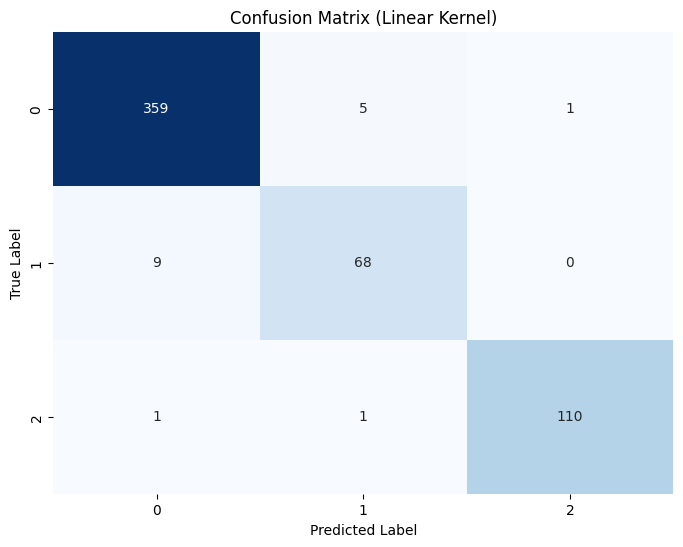

In [22]:
# Create and train SVM classifier with linear kernel
clf_linear = svm.SVC(kernel='linear')
clf_linear.fit(X_train, y_train)
y_pred_linear = clf_linear.predict(X_test)
accuracy_linear = accuracy_score(y_test, y_pred_linear)
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)
print("Accuracy - ",accuracy_linear)

# Plot confusion matrix for linear kernel
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_linear, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix (Linear Kernel)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Polynomial Kernel

C = 1

0.9783393501805054


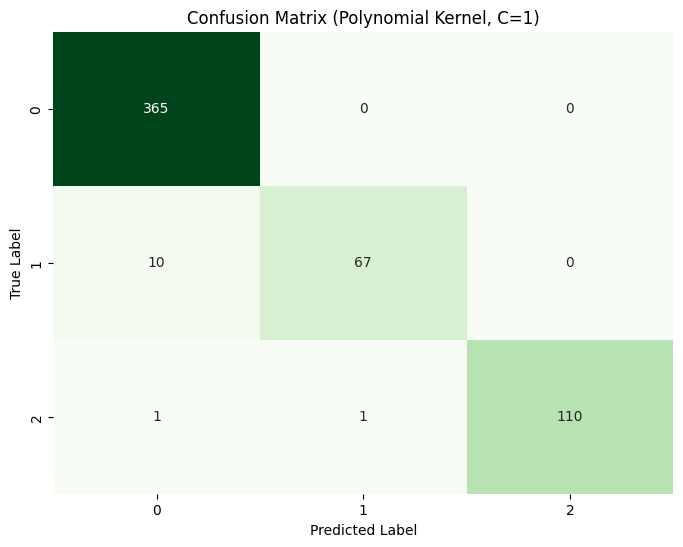

In [29]:

C = 1  # Example value, adjust as needed
clf_poly = svm.SVC(kernel='poly', C=C)
clf_poly.fit(X_train, y_train)
y_pred_poly = clf_poly.predict(X_test)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
conf_matrix_poly = confusion_matrix(y_test, y_pred_poly)


print(accuracy_poly)
# Plot confusion matrix for polynomial kernel
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_poly, annot=True, cmap="Greens", fmt="d", cbar=False)
plt.title(f"Confusion Matrix (Polynomial Kernel, C={C})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


C = 0.1

0.9747292418772563


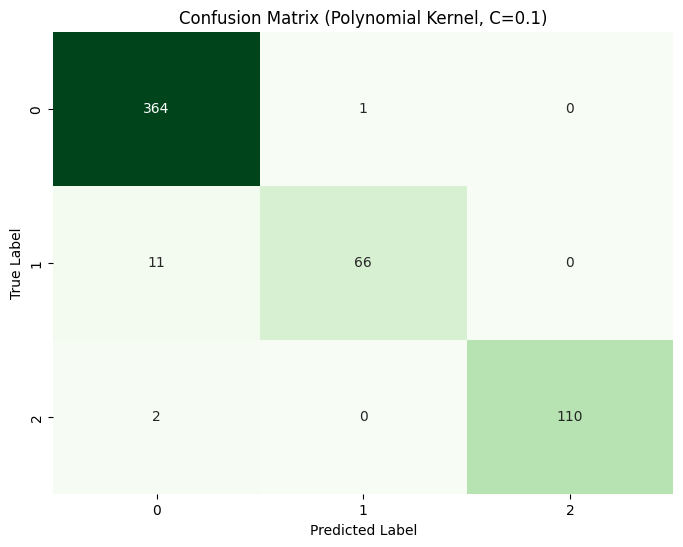

In [31]:

C = 0.1  # Example value, adjust as needed
clf_poly = svm.SVC(kernel='poly', C=C)
clf_poly.fit(X_train, y_train)
y_pred_poly = clf_poly.predict(X_test)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
conf_matrix_poly = confusion_matrix(y_test, y_pred_poly)

print(accuracy_poly)
# Plot confusion matrix for polynomial kernel
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_poly, annot=True, cmap="Greens", fmt="d", cbar=False)
plt.title(f"Confusion Matrix (Polynomial Kernel, C={C})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

C=10

0.98014440433213


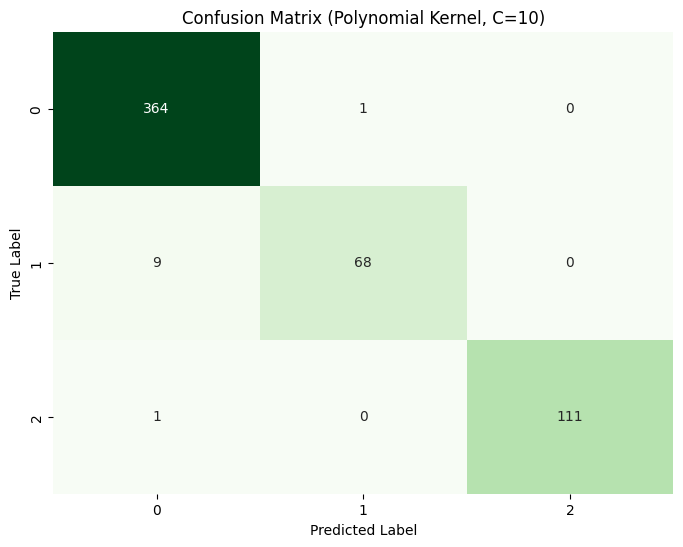

In [32]:

C = 10  
clf_poly = svm.SVC(kernel='poly', C=C)
clf_poly.fit(X_train, y_train)
y_pred_poly = clf_poly.predict(X_test)
accuracy_poly = accuracy_score(y_test, y_pred_poly)
conf_matrix_poly = confusion_matrix(y_test, y_pred_poly)

print(accuracy_poly)
# Plot confusion matrix for polynomial kernel
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_poly, annot=True, cmap="Greens", fmt="d", cbar=False)
plt.title(f"Confusion Matrix (Polynomial Kernel, C={C})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### RBF
C=1

0.9711191335740073


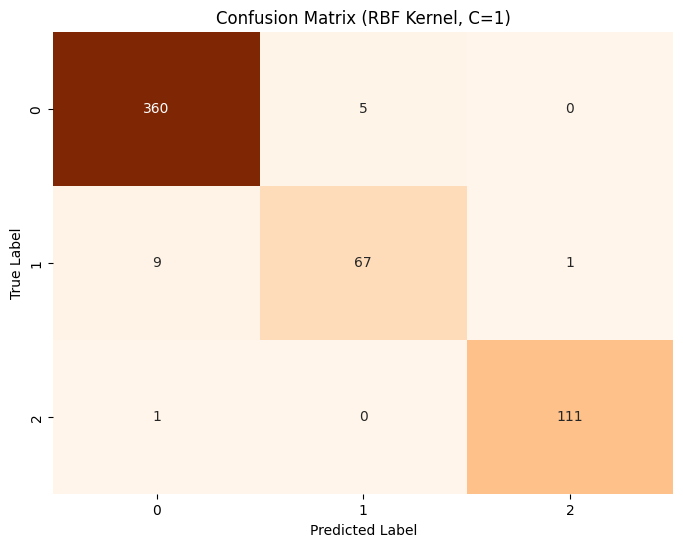

In [33]:
# Repeat for RBF kernel
C = 1 
clf_rbf = svm.SVC(kernel='rbf', C=C)
clf_rbf.fit(X_train, y_train)
y_pred_rbf = clf_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf)
print(accuracy_rbf)
# Plot confusion matrix for RBF kernel
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rbf, annot=True, cmap="Oranges", fmt="d", cbar=False)
plt.title(f"Confusion Matrix (RBF Kernel, C={C})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

C=0.1

0.9584837545126353


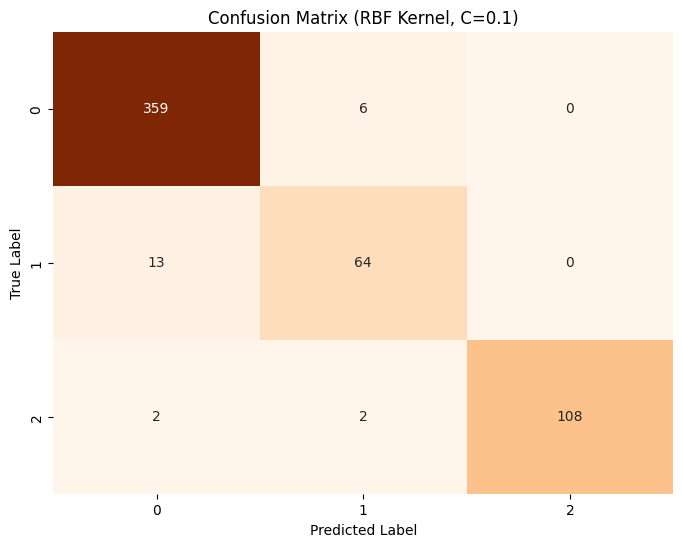

In [34]:
# Repeat for RBF kernel
C = 0.1  
clf_rbf = svm.SVC(kernel='rbf', C=C)
clf_rbf.fit(X_train, y_train)
y_pred_rbf = clf_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf)
print(accuracy_rbf)
# Plot confusion matrix for RBF kernel
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rbf, annot=True, cmap="Oranges", fmt="d", cbar=False)
plt.title(f"Confusion Matrix (RBF Kernel, C={C})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

C=10

0.9584837545126353


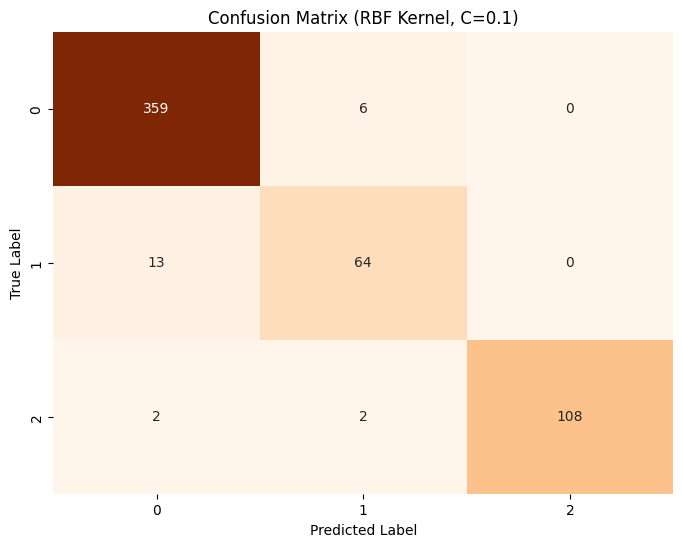

In [35]:
# Repeat for RBF kernel
C = 0.1  
clf_rbf = svm.SVC(kernel='rbf', C=C)
clf_rbf.fit(X_train, y_train)
y_pred_rbf = clf_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf)
print(accuracy_rbf)
# Plot confusion matrix for RBF kernel
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rbf, annot=True, cmap="Oranges", fmt="d", cbar=False)
plt.title(f"Confusion Matrix (RBF Kernel, C={C})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The Best model comparing different kernel options we found out that Polynomial Kernel with the regularization parameter of 10. 


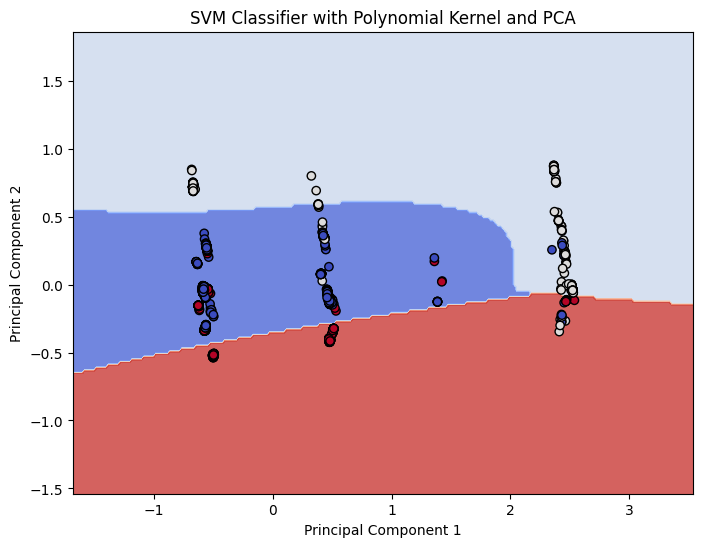

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce features to 2 dimensions
pca = PCA(n_components=2)
X = pca.fit_transform(X)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_poly = svm.SVC(kernel='poly', C=10)
clf_poly.fit(X_train, y_train)
y_pred_poly = clf_poly.predict(X_test)


# Plot decision boundary and data points
plt.figure(figsize=(8, 6))

# Plot decision boundary
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf_poly.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Classifier with Polynomial Kernel and PCA')

plt.show()